# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet и дообучить под нашу задачу. 

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# https://www.kaggle.com/general/74235 - описывается возможность загружать данные из kaggle в colab
!pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# check
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
shivan118/healthcare-analytics                         AV : Healthcare Analytics                           2MB  2020-09-13 17:40:05           1493  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification        4MB  2020-09-08 11:40:11            885  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           1964  
Cornell-University/arxiv                               arXiv Dataset                                     888MB  2020-09-22 15:33:49           3027  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND E

In [ ]:
# копируем датасеты из kaggle в локальную папку kaggle-data в colab
! kaggle competitions download -c 'sf-dl-car-classification' -p 'kaggle-data'

  0% 0.00/196k [00:00<?, ?B/s]
100% 196k/196k [00:00<00:00, 73.3MB/s]
100% 489M/489M [00:05<00:00, 68.8MB/s]
100% 489M/489M [00:05<00:00, 99.9MB/s]
100% 1.10G/1.11G [00:14<00:00, 51.3MB/s]
100% 1.11G/1.11G [00:14<00:00, 84.6MB/s]
  0% 0.00/78.7k [00:00<?, ?B/s]
100% 78.7k/78.7k [00:00<00:00, 72.1MB/s]


In [ ]:
# пытаюсь обучить сеть на TPU, пока сложности
#!pip install tf-nightly
#!pip install tensorflow==2.3.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import pprint
import tqdm
import csv
import sys
import os

import imgaug as ia
import imageio
from imgaug.augmentables.segmaps import SegmentationMapOnImage
from imgaug import augmenters as iaa
from ImageDataAugmentor.image_data_augmentor import *

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("kaggle-data"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['train.csv', 'train.zip', 'sample-submission.csv', 'test.zip']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


In [ ]:
# здесь также пытаюсь обучить сеть на TPU 
"""
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.compat.v1.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)
"""

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU (16 уже не влезало в colab)
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 400 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = 'kaggle-data/'
! mkdir working
PATH = 'working/' # рабочая директория

mkdir: cannot create directory ‘working’: File exists


In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
sample_submission.head()

,Id,Category
0,305108.jpg,0
1,295075.jpg,0
2,31197.jpg,0
3,93598.jpg,0
4,87877.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile('kaggle-data/' + data_zip, 'r') as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


,Id,Category
99,111114.jpg,0
8450,157246.jpg,5
2882,222821.jpg,1
2177,156050.jpg,1
12856,137541.jpg,8
1358,267157.jpg,0
3877,140880.jpg,2
4192,18482.jpg,2
7713,259368.jpg,4


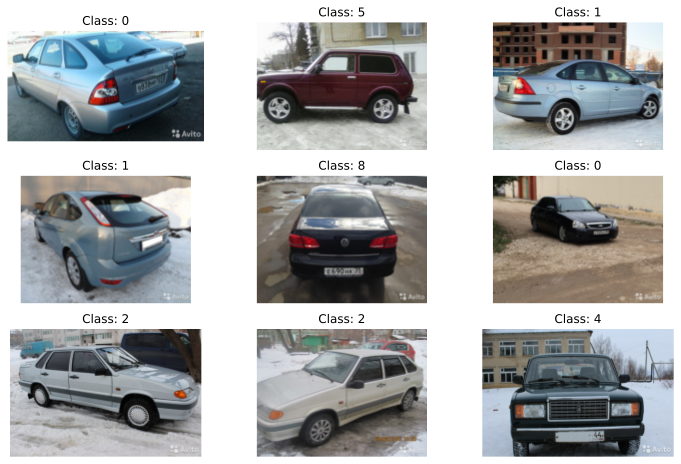

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

display(random_image)

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать. Выбираем рандомный класс и имя файла

In [ ]:
# helper function, returns a random image from dataset
def get_random_image():
  car_class = np.random.randint(0, 10)
  car_id = train_df[train_df['Category'] == car_class].sample().iloc[0].at['Id']
  full_path = PATH + f'train/{car_class}/{car_id}'

  return PIL.Image.open(full_path), imageio.imread(full_path)

# Подготовка данных

### Аугментация данных

In [ ]:
# выбрал библиотеку imgaug для аугментации и обертку ImageDataAugmentor
! pip install imgaug
! pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [ ]:
image, image_io = get_random_image()

(640, 480)
(480, 640, 3)


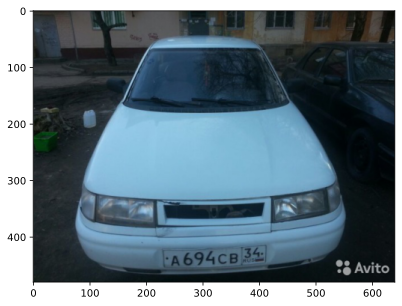

In [ ]:
print(image.size)
print(image_io.shape)

#imgaug.imshow(image)
imgaug.imshow(image_io)

In [ ]:
# подготовка методов аугментации
sometimes = lambda aug: iaa.Sometimes(0.5, aug) # будем брать около половины изображений для обработки
AUGMENTATIONS = iaa.Sequential([
  iaa.Fliplr(0.6), # 60% картинок отразим по горизонтали

  iaa.Sometimes(0.5, iaa.CropAndPad( # обрезка и заполнение краев пикселями
                percent=(-0.05, 0.1), 
                pad_mode=ia.ALL,
                pad_cval=(0, 255)
            )),
  
  iaa.Sometimes(
        0.7, iaa.Affine(scale={"x": (0.8, 1.3), "y": (0.8, 1.3)}, # масштабирование от 80 до 120% от размера картинки
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # перемещение
                        rotate=(-10, 10), # поворот
                        shear=(-10, 10), # сдвиг
                        order=[0, 1],
                        cval=(0, 255),
                        mode=ia.ALL
        )),

  iaa.SomeOf((0, 5), # применяем от 0 до 5 методов в списке
            [
                iaa.Sometimes(0.6, iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)), 
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # рандомно удядлем до 10 % пикселей
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # инвертирование цветовых каналов
                iaa.Add((-10, 10), per_channel=0.5), # меняем яркость
                iaa.AddToHueAndSaturation((-20, 20)),
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )  
], random_order=True) # весь выбор в рандомном порядке

In [ ]:
train_augmentor = ImageDataAugmentor(augment=AUGMENTATIONS, rescale=1. / 255, validation_split=VAL_SPLIT)
test_augmentor = ImageDataAugmentor(rescale=1. / 255)

In [ ]:
train_aug_gen = train_augmentor.flow_from_directory(directory=PATH + 'train/', 
                                                    target_size=(IMG_SIZE, IMG_SIZE), 
                                                    batch_size=BATCH_SIZE, 
                                                    seed=RANDOM_SEED, 
                                                    subset='training')

validation_aug_gen = train_augmentor.flow_from_directory(directory=PATH + 'train/', 
                                                         target_size=(IMG_SIZE, IMG_SIZE), 
                                                         batch_size=BATCH_SIZE, 
                                                         seed=RANDOM_SEED, 
                                                         subset='validation')

test_gen = test_augmentor.flow_from_dataframe(dataframe=sample_submission, 
                                              directory=PATH + 'test_upload/', 
                                              x_col='Id',
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              class_mode=None, 
                                              shuffle=False, 
                                              seed=RANDOM_SEED, 
                                              batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


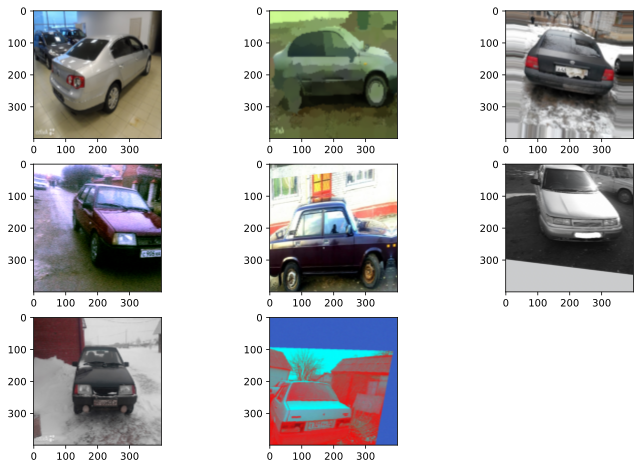

In [ ]:
# пример аугментированных данных
ax, ay = train_aug_gen.next()
plt.figure(figsize=(12, 8))

for i in range(8):
  pic = ax[i]
  plt.subplot(3,3, i+1)
  plt.imshow(pic)

plt.show()

### Генерация данных

# Построение модели

### Загружаем предобученную сеть Xception:

In [ ]:
#base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
# решил попробовать EfficientNetB4, так как качество высокое и скорость обучения быстрая
base_model = EfficientNetB4(include_top=False, input_shape=input_shape)

71688192/71686520 [==============================] - 0s 0us/step


In [ ]:
len(base_model.layers)

474

In [ ]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=16, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.10)(x)
x = GlobalMaxPooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.10)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
# на нечетных эпохах уменьшаем lr на один разряд
def scheduler(epoch, lr):
  if epoch % 2 == 0:
    return lr
  else:
    return lr * 0.1#tf.math.exp(-0.1)

checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_accuracy'], verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=tf.math.exp(-0.1), patience=1, min_lr=LR, verbose=1)
scheduler_lr = LearningRateScheduler(schedule=scheduler, verbose=1)

callbacks_list = [checkpoint, reduce_lr, scheduler_lr]

Обучаем:

In [ ]:
clear_session()

In [ ]:
"""
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
#tf.logging.set_verbosity(tf.logging.INFO)
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.TPUStrategy(cluster_resolver)
#model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
"""

In [ ]:
"""
with tpu_strategy.scope():
  train_augmentor = ImageDataAugmentor(augment=AUGMENTATIONS, rescale=1. / 255, validation_split=VAL_SPLIT)
  test_augmentor = ImageDataAugmentor(rescale=1. / 255)


  train_aug_gen = train_augmentor.flow_from_directory(directory=PATH + 'train/', 
                                                    target_size=(IMG_SIZE, IMG_SIZE), 
                                                    batch_size=BATCH_SIZE, 
                                                    seed=RANDOM_SEED, 
                                                    subset='training')

  validation_aug_gen = train_augmentor.flow_from_directory(directory=PATH + 'train/', # тут не было слеша 
                                                         target_size=(IMG_SIZE, IMG_SIZE), 
                                                         batch_size=BATCH_SIZE, 
                                                         seed=RANDOM_SEED, 
                                                         subset='validation')

  test_gen = test_augmentor.flow_from_dataframe(dataframe=sample_submission, 
                                              directory=PATH + 'test_upload/', 
                                              x_col='Id',
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              class_mode=None, 
                                              shuffle=False, 
                                              seed=RANDOM_SEED, 
                                              batch_size=BATCH_SIZE)


  base_model = EfficientNetB4(include_top=False, input_shape=input_shape)

  # Устанавливаем новую "голову" (head)

  x = base_model.output
  x = BatchNormalization()(x)
  x = GlobalMaxPooling2D()(x)
  x = BatchNormalization()(x)
  #x = MaxPooling2D()(x)
  x = Dropout(0.05)(x)
  #x = Flatten()(x)
  #x = Dropout(0.25)(x)
  x = Dense(128, activation=tf.nn.relu)(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation=tf.nn.relu)(x)
  x = Dropout(0.5)(x)
  predictions = Dense(CLASS_NUM, activation=tf.nn.softmax)(x)

# this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])
"""

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
clear_session()

In [ ]:
"""
from tensorflow.raw_ops import OptimizeDatasetV2
def scheduler(epoch, lr):
    if epoch % 2 == 0:
      return lr
    else:
      return lr * 0.1#tf.math.exp(-0.1)

checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_accuracy'], verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=tf.math.exp(-0.1), patience=1, min_lr=LR, verbose=1)
scheduler_lr = LearningRateScheduler(schedule=scheduler, verbose=1)

callbacks_list = [checkpoint, reduce_lr, scheduler_lr]


history = model.fit_generator(
        train_aug_gen,
        steps_per_epoch = len(train_aug_gen),
        validation_data = validation_aug_gen, 
        validation_steps = len(validation_aug_gen),
        epochs = EPOCHS
        #callbacks = callbacks_list
)
"""

In [ ]:
# обучение
history = model.fit(
        train_aug_gen,
        steps_per_epoch = len(train_aug_gen),
        validation_data = validation_aug_gen, 
        validation_steps = len(validation_aug_gen),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
from google.colab import files
model.save('working/model_last.hdf5')
files.download('working/model_last.hdf5')
files.download('best_model.hdf5')

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

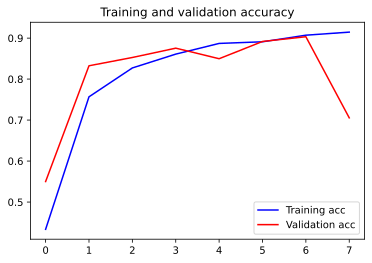

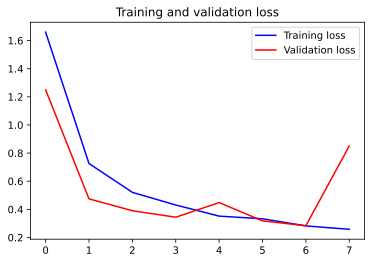

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [ ]:
test_gen.samples

6675

In [ ]:
pred = np.mean(predictions, axis=0)
pred = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_aug_gen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions_total = [label_map[k] for k in pred]

In [ ]:
test_gen.reset()
predictions = model.predict(test_gen, steps=len(test_gen), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_aug_gen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 73s 88ms/step


In [ ]:
predictions.shape

(6675, 10)

In [ ]:
filenames_with_dir=test_gen.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(PATH+'submission_mean_2.csv', index=False)
print('Save submit')

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,1
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)